# Text processing

## Init spark

In [11]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sc = SparkContext(conf=SparkConf())
spark = SparkSession(sparkContext=sc)

## Dummy data

In [7]:
f = open('./books/10000.txt', "r")
text = f.read()


In [9]:
from gutenberg.cleanup import strip_headers
strip_headers(text).strip()

'A note from Michael Hart, preparer of the 0.1 version.\n\nThis file contains a number of versions of the Magna Carta,\nsome of which were a little mangled in transit.  I am sure\nour volunteers will find and correct errors I didn\'t catch,\nand that version 0.2 - 1.0 will have significant improvements,\nas well as at least one more version in Latin.\n\nVersion 1.0 may contain a dozen different versions.\n\n\n\n\n\nThe Text of Magna Carta\n\nJOHN, by the grace of God King of England, Lord of Ireland, Duke of\nNormandy and Aquitaine, and Count of Anjou, to his archbishops,\nbishops, abbots, earls, barons, justices, foresters, sheriffs,\nstewards, servants, and to all his officials and loyal subjects,\nGreeting.\n\nKNOW THAT BEFORE GOD, for the health of our soul and those of our\nancestors and heirs, to the honour of God, the exaltation of the holy\nChurch, and the better ordering of our kingdom, at the advice of our\nreverend fathers Stephen, archbishop of Canterbury, primate of all\nE

In [59]:
import pandas as pd

pdf = pd.DataFrame({
        'texts': ["I like playing?and drinking hello",
                  "I like coding.",
                  "Hello world spark python"]})
    
df = spark.createDataFrame(pdf)
df.show()

+--------------------+
|               texts|
+--------------------+
|I like playing?an...|
|      I like coding.|
|Hello world spark...|
+--------------------+



## Clean text

In [60]:
%%time
import re
import unidecode
from pyspark.sql.functions import udf
from pyspark.sql.types import *

def clean(text):
    text= unidecode.unidecode(text) # remove accents
    text = text.lower()
    text = text.replace(r'\n','') # remove newline sign
    text = re.sub(r'\d+', '', text) # remove digits 
    text = re.sub(r'[.]?-[.]?', '', text) # concatenate divided words
    text = re.sub(r'[\W]+',' ', text) # replace non-alphanum with space  
    text = re.sub(' +', ' ', text) # replace multiple spaces with single space 
    return text

user_def_fun = udf(f=clean, returnType=StringType())

df = df.withColumn("cleaned", user_def_fun("texts"))
df.show()

+--------------------+--------------------+
|               texts|             cleaned|
+--------------------+--------------------+
|I like playing?an...|i like playing an...|
|      I like coding.|      i like coding |
|Hello world spark...|hello world spark...|
+--------------------+--------------------+

CPU times: user 8.64 ms, sys: 533 µs, total: 9.17 ms
Wall time: 276 ms


## Tokenization

In [61]:
%%time
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="cleaned", outputCol="tokens")
df = tokenizer.transform(df)
df.show(2, False)

+---------------------------------+---------------------------------+----------------------------------------+
|texts                            |cleaned                          |tokens                                  |
+---------------------------------+---------------------------------+----------------------------------------+
|I like playing?and drinking hello|i like playing and drinking hello|[i, like, playing, and, drinking, hello]|
|I like coding.                   |i like coding                    |[i, like, coding]                       |
+---------------------------------+---------------------------------+----------------------------------------+
only showing top 2 rows

CPU times: user 4.66 ms, sys: 3.51 ms, total: 8.17 ms
Wall time: 296 ms


## Stopwords Removal

In [62]:
%%time
from pyspark.ml.feature import StopWordsRemover

stopword_removal = StopWordsRemover(inputCol='tokens', 
                                    outputCol='refined_tokens')
df = stopword_removal.transform(df)

df.show(2, False)

+---------------------------------+---------------------------------+----------------------------------------+--------------------------------+
|texts                            |cleaned                          |tokens                                  |refined_tokens                  |
+---------------------------------+---------------------------------+----------------------------------------+--------------------------------+
|I like playing?and drinking hello|i like playing and drinking hello|[i, like, playing, and, drinking, hello]|[like, playing, drinking, hello]|
|I like coding.                   |i like coding                    |[i, like, coding]                       |[like, coding]                  |
+---------------------------------+---------------------------------+----------------------------------------+--------------------------------+
only showing top 2 rows

CPU times: user 58.5 ms, sys: 13.5 ms, total: 72 ms
Wall time: 413 ms


## Stemming vs lemmatization

### SnowballStemmer

In [63]:
%%time
from nltk.stem.snowball import SnowballStemmer

def list_stemmer(words):
    stemmer = SnowballStemmer(language='english')
    return [stemmer.stem(word) for word in words]

stemming = udf(list_stemmer, returnType=ArrayType(StringType()))

df = df.withColumn("stem", stemming("refined_tokens"))
df.select(['refined_tokens','stem']).show(2, False)

+--------------------------------+--------------------------+
|refined_tokens                  |stem                      |
+--------------------------------+--------------------------+
|[like, playing, drinking, hello]|[like, play, drink, hello]|
|[like, coding]                  |[like, code]              |
+--------------------------------+--------------------------+
only showing top 2 rows

CPU times: user 8.36 ms, sys: 4.34 ms, total: 12.7 ms
Wall time: 3.06 s


### WordNetLemmatizer

In [ ]:
import nltk
nltk.download('wordnet')

In [62]:
%%time
from nltk.stem import WordNetLemmatizer

def list_lemmatizer(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

lemmatization = udf(list_lemmatizer, returnType=ArrayType(StringType()))

df = df.withColumn("lem", lemmatization("refined_tokens"))
df.select(['refined_tokens','lem']).show(2, False)

+--------------------+--------------------+
|      refined_tokens|                 lem|
+--------------------+--------------------+
|[like, playing, d...|[like, playing, d...|
|      [like, coding]|      [like, coding]|
+--------------------+--------------------+

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 5.2 s


## TF-IDF

In [58]:
%%time
from pyspark.ml.feature import HashingTF, IDF

hashing_vec = HashingTF(numFeatures=262144,
                        inputCol='stem',
                        outputCol='tf_features')

hashing_df = hashing_vec.transform(df)
hashing_df.select(['stem','tf_features']).show(2, False)

+--------------------------+-------------------------------------------------------+
|stem                      |tf_features                                            |
+--------------------------+-------------------------------------------------------+
|[like, play, drink, hello]|(262144,[33140,123981,208258,250593],[1.0,1.0,1.0,1.0])|
|[like, code]              |(262144,[93284,208258],[1.0,1.0])                      |
+--------------------------+-------------------------------------------------------+
only showing top 2 rows

CPU times: user 19.2 ms, sys: 12.2 ms, total: 31.4 ms
Wall time: 2.78 s


In [64]:
%%time
tf_idf_vec = IDF(inputCol='tf_features',
               outputCol='tf_idf_features')

tf_idf_df = tf_idf_vec.fit(hashing_df).transform(hashing_df)
tf_idf_df.select(['stem','tf_idf_features']).show(2,False)

+--------------------------+---------------------------------------------------------------------------------------------------------------------+
|stem                      |tf_idf_features                                                                                                      |
+--------------------------+---------------------------------------------------------------------------------------------------------------------+
|[like, play, drink, hello]|(262144,[33140,123981,208258,250593],[0.6931471805599453,0.6931471805599453,0.28768207245178085,0.28768207245178085])|
|[like, code]              |(262144,[93284,208258],[0.6931471805599453,0.28768207245178085])                                                     |
+--------------------------+---------------------------------------------------------------------------------------------------------------------+
only showing top 2 rows

CPU times: user 13.1 ms, sys: 5.41 ms, total: 18.6 ms
Wall time: 5.81 s


## PCA

In [148]:
%%time
from pyspark.ml.feature import PCA 
from pyspark.ml.linalg import Vectors

pca = PCA(k=2, inputCol='tf_idf_features', outputCol="pca")
model = pca.fit(tf_idf_df)
transformed = model.transform(tf_idf_df)
transformed = transformed.select('pca')
transformed.show(2, False) 

+-----------------------------------------+
|pca                                      |
+-----------------------------------------+
|[0.5026488372437357,-0.7356385322948846] |
|[0.16366648734159395,0.45146339383428075]|
+-----------------------------------------+
only showing top 2 rows

CPU times: user 17.5 ms, sys: 15.4 ms, total: 32.9 ms
Wall time: 24.1 s


### split vectors in to two columns

In [150]:
from pyspark.sql import Row
from pyspark.sql.types import *

two_columns_rdd = transformed.rdd.map(lambda x: Row(PCA_1=float(x[0][0]), 
                                                    PCA_2=float(x[0][1])))

schema = StructType([StructField("PCA_1", FloatType(), True),
                     StructField("PCA_2", FloatType(), True)])

pca_df = spark.createDataFrame(two_columns_rdd, schema=schema)
pca_df.show(2)

+----------+-----------+
|     PCA_1|      PCA_2|
+----------+-----------+
|0.50264883|-0.73563856|
|0.16366649|  0.4514634|
+----------+-----------+
only showing top 2 rows



# Visualization

In [158]:
plot_df = pca_df.toPandas()
x, y = plot_df['PCA_1'].values, plot_df['PCA_2'].values

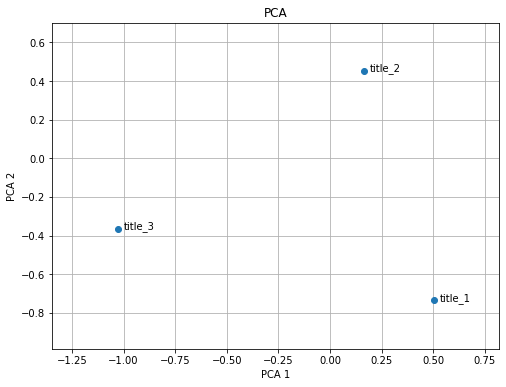

In [175]:
import matplotlib.pyplot as plt

titles = ['title_1','title_2','title_3']

fig, ax = plt.subplots(figsize=(8,6))

ax.set_xmargin(0.2)
ax.set_ymargin(0.2)
ax.scatter(x,y, zorder=3)

# Display titles
for i, title in enumerate(titles):
    ax.annotate(title, (x[i]+0.03, y[i]))
    
ax.set(xlabel='PCA 1',
       ylabel='PCA 2', 
       title='PCA')
ax.grid()

plt.show()

# Clusterization

In [178]:
from sklearn.cluster import KMeans

clustering_model = KMeans(n_clusters=3,
                          max_iter=100,
                          n_jobs=-1)

labels = clustering_model.fit_predict(plot_df)

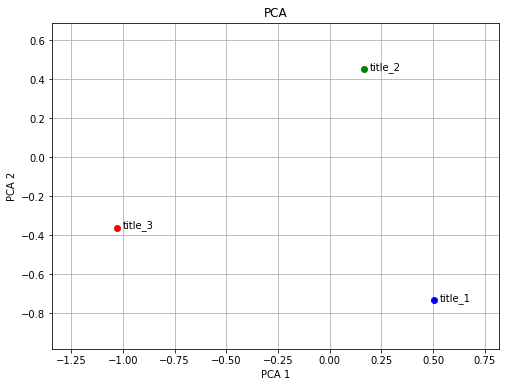

In [182]:
color_map = {0: 'red', 
             1: 'green', 
             2: 'blue'}
    
titles = ['title_1','title_2','title_3']

fig, ax = plt.subplots(figsize=(8,6))

ax.set_xmargin(0.2)
ax.set_ymargin(0.2)

for i, _ in enumerate(x):
    # Add colors
    color = color_map[labels[i]]
    ax.scatter(x[i], y[i], c=color, zorder=3)
    # Display titles
    ax.annotate(titles[i], (x[i]+0.03, y[i]))
    
ax.set(xlabel='PCA 1',
       ylabel='PCA 2', 
       title='PCA')
ax.grid()

plt.show()